# Auto-Arima and LGBM

In [1]:
import os
import datetime
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
!pip install pmdarima
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

data_dir= os.path.join(os.getcwd(),"data","IoTData.xlsx")
Preprocessed_data = pd.read_excel(data_dir)
Preprocessed_data.head()

  Using cached Cython-0.29.17-cp37-cp37m-win_amd64.whl (1.7 MB)
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


,DATETIME,TEMP_AIR,UMIDADE_REL,KW,KW2
0,2019-09-15 00:00:00,18.7,80.0,690.48,69.048
1,2019-09-15 01:00:00,18.2,83.0,685.44,68.544
2,2019-09-15 02:00:00,18.2,83.0,656.88,65.688
3,2019-09-15 03:00:00,18.2,83.0,655.20,65.520
4,2019-09-15 04:00:00,18.3,82.0,660.24,66.024


In [2]:
Preprocessed_data.isna().sum()

DATETIME       0
TEMP_AIR       1
UMIDADE_REL    1
KW             0
KW2            0
dtype: int64

In [21]:
Preprocessed_data.shape

(8336, 20)

In [3]:
Preprocessed_data=Preprocessed_data.drop(columns=["KW2"])
from sklearn.impute import SimpleImputer
Preprocessed_data['TEMP_AIR'].fillna(Preprocessed_data['TEMP_AIR'].mean(), inplace=True)
Preprocessed_data['UMIDADE_REL'].fillna(Preprocessed_data['UMIDADE_REL'].mean(),inplace=True)
Preprocessed_data.head()

,DATETIME,TEMP_AIR,UMIDADE_REL,KW
0,2019-09-15 00:00:00,18.7,80.0,690.48
1,2019-09-15 01:00:00,18.2,83.0,685.44
2,2019-09-15 02:00:00,18.2,83.0,656.88
3,2019-09-15 03:00:00,18.2,83.0,655.20
4,2019-09-15 04:00:00,18.3,82.0,660.24


Text(0.5, 1.0, 'Energy Distribution')

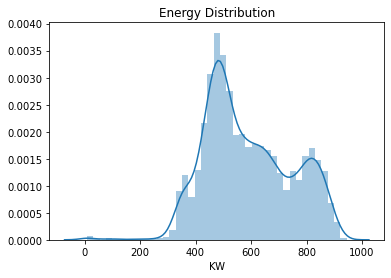

In [4]:
import seaborn as sns

sns.distplot(Preprocessed_data["KW"])
plt.title("Energy Distribution")

In [5]:
Preprocessed_data.set_index("DATETIME", drop=False, inplace=True)
Preprocessed_data.head()

,DATETIME,TEMP_AIR,UMIDADE_REL,KW
DATETIME,,,,
2019-09-15 00:00:00,2019-09-15 00:00:00,18.7,80.0,690.48
2019-09-15 01:00:00,2019-09-15 01:00:00,18.2,83.0,685.44
2019-09-15 02:00:00,2019-09-15 02:00:00,18.2,83.0,656.88
2019-09-15 03:00:00,2019-09-15 03:00:00,18.2,83.0,655.20
2019-09-15 04:00:00,2019-09-15 04:00:00,18.3,82.0,660.24


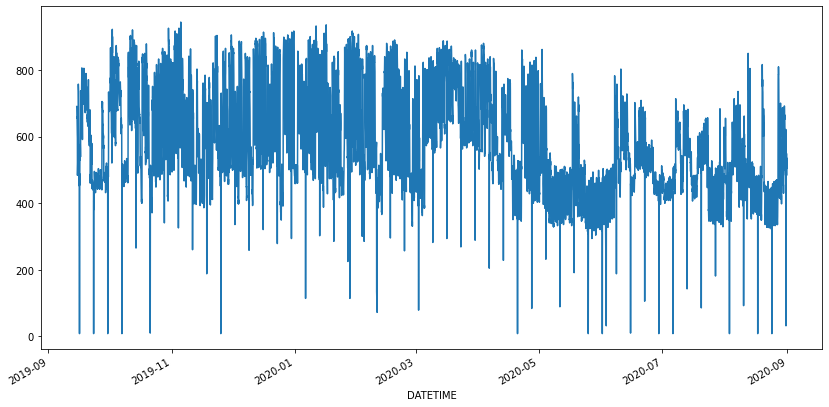

In [6]:
Preprocessed_data.KW.plot(figsize=(14, 7))

In [8]:
df = Preprocessed_data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8336 entries, 2019-09-15 00:00:00 to 2020-08-31 20:00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATETIME     8336 non-null   datetime64[ns]
 1   TEMP_AIR     8336 non-null   float64       
 2   UMIDADE_REL  8336 non-null   float64       
 3   KW           8336 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 325.6 KB


In [9]:
df.reset_index(drop=True, inplace=True)
lag_features = ["TEMP_AIR", "UMIDADE_REL"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("DATETIME", drop=False, inplace=True)
df.head()

,DATETIME,TEMP_AIR,UMIDADE_REL,KW,TEMP_AIR_mean_lag3,TEMP_AIR_mean_lag7,TEMP_AIR_mean_lag30,TEMP_AIR_std_lag3,TEMP_AIR_std_lag7,TEMP_AIR_std_lag30,UMIDADE_REL_mean_lag3,UMIDADE_REL_mean_lag7,UMIDADE_REL_mean_lag30,UMIDADE_REL_std_lag3,UMIDADE_REL_std_lag7,UMIDADE_REL_std_lag30
DATETIME,,,,,,,,,,,,,,,,
2019-09-15 00:00:00,2019-09-15 00:00:00,18.7,80.0,690.48,20.425535,20.425081,20.424458,7.759067e-01,1.522793,2.958062,67.784393,67.78743,67.798393,3.591338,6.756948,12.798696
2019-09-15 01:00:00,2019-09-15 01:00:00,18.2,83.0,685.44,18.700001,18.700001,18.700001,7.759067e-01,1.522793,2.958062,80.000000,80.00000,80.000000,3.591338,6.756948,12.798696
2019-09-15 02:00:00,2019-09-15 02:00:00,18.2,83.0,656.88,18.450001,18.450001,18.450001,3.535534e-01,0.353553,0.353553,81.500000,81.50000,81.500000,2.121320,2.121320,2.121320
2019-09-15 03:00:00,2019-09-15 03:00:00,18.2,83.0,655.20,18.366667,18.366667,18.366667,2.886751e-01,0.288675,0.288675,82.000000,82.00000,82.000000,1.732051,1.732051,1.732051
2019-09-15 04:00:00,2019-09-15 04:00:00,18.3,82.0,660.24,18.200001,18.325001,18.325001,3.434548e-08,0.250000,0.250000,83.000000,82.25000,82.250000,0.000000,1.500000,1.500000


In [10]:
df.DATETIME = pd.to_datetime(df.DATETIME, format="%Y-%m-%d")
df["year"] = df.DATETIME.dt.year
df["month"] = df.DATETIME.dt.month
df["week"] = df.DATETIME.dt.week
df["day"] = df.DATETIME.dt.day
df["day_of_week"] = df.DATETIME.dt.dayofweek
df.head()

,DATETIME,TEMP_AIR,UMIDADE_REL,KW,TEMP_AIR_mean_lag3,TEMP_AIR_mean_lag7,TEMP_AIR_mean_lag30,TEMP_AIR_std_lag3,TEMP_AIR_std_lag7,TEMP_AIR_std_lag30,...,UMIDADE_REL_mean_lag7,UMIDADE_REL_mean_lag30,UMIDADE_REL_std_lag3,UMIDADE_REL_std_lag7,UMIDADE_REL_std_lag30,year,month,week,day,day_of_week
DATETIME,,,,,,,,,,,,,,,,,,,,,
2019-09-15 00:00:00,2019-09-15 00:00:00,18.7,80.0,690.48,20.425535,20.425081,20.424458,7.759067e-01,1.522793,2.958062,...,67.78743,67.798393,3.591338,6.756948,12.798696,2019,9,37,15,6
2019-09-15 01:00:00,2019-09-15 01:00:00,18.2,83.0,685.44,18.700001,18.700001,18.700001,7.759067e-01,1.522793,2.958062,...,80.00000,80.000000,3.591338,6.756948,12.798696,2019,9,37,15,6
2019-09-15 02:00:00,2019-09-15 02:00:00,18.2,83.0,656.88,18.450001,18.450001,18.450001,3.535534e-01,0.353553,0.353553,...,81.50000,81.500000,2.121320,2.121320,2.121320,2019,9,37,15,6
2019-09-15 03:00:00,2019-09-15 03:00:00,18.2,83.0,655.20,18.366667,18.366667,18.366667,2.886751e-01,0.288675,0.288675,...,82.00000,82.000000,1.732051,1.732051,1.732051,2019,9,37,15,6
2019-09-15 04:00:00,2019-09-15 04:00:00,18.3,82.0,660.24,18.200001,18.325001,18.325001,3.434548e-08,0.250000,0.250000,...,82.25000,82.250000,0.000000,1.500000,1.500000,2019,9,37,15,6


In [13]:
# How many Unique Year do we Have in Dataset 
print(df.year.unique(),"\n")
print(df.month.unique(),"\n")
print("Total Number of Unique Year", df.year.unique(), "\n")
print("Total Number of Unique Months", df.month.unique(), "\n")


[2019 2020] 

[ 9 10 11 12  1  2  3  4  5  6  7  8] 

Total Number of Unique Year [2019 2020] 

Total Number of Unique Months [ 9 10 11 12  1  2  3  4  5  6  7  8] 



# We have data for 1 year only... So understand pattern for each year, we need more data.

In [16]:
split_date = '2020-06-30'
df_train = df[df.DATETIME < split_date]
df_valid = df[df.DATETIME >= split_date]

exogenous_features = ['TEMP_AIR_mean_lag3',
       'TEMP_AIR_mean_lag7', 'TEMP_AIR_mean_lag30', 'TEMP_AIR_std_lag3',
       'TEMP_AIR_std_lag7', 'TEMP_AIR_std_lag30', 'UMIDADE_REL_mean_lag3',
       'UMIDADE_REL_mean_lag7', 'UMIDADE_REL_mean_lag30',
       'UMIDADE_REL_std_lag3', 'UMIDADE_REL_std_lag7', 'UMIDADE_REL_std_lag30',
       'month', 'week', 'day', 'day_of_week']

In [18]:
print("Training Set Shape ", df_train.shape)
print("Validation Set Shape ", df_valid.shape)

Training Set Shape  (6834, 21)
Validation Set Shape  (1502, 21)


In [11]:
model = auto_arima(df_train.KW, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.KW, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=37.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=77309.406, Time=1.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=76876.879, Time=22.43 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=76787.089, Time=39.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=77307.406, Time=13.64 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=38.54 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=76768.638, Time=33.70 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=39.02 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=76767.231, Time=40.51 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=49.69 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=76758.547, Time=42.37 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=59.71 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=76682.071, Time=47.14 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=66.39 sec
 ARIMA(0,1,5)(0,0,0)[0]             : AIC=

C:\Users\AshwiniShitole\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\AshwiniShitole\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


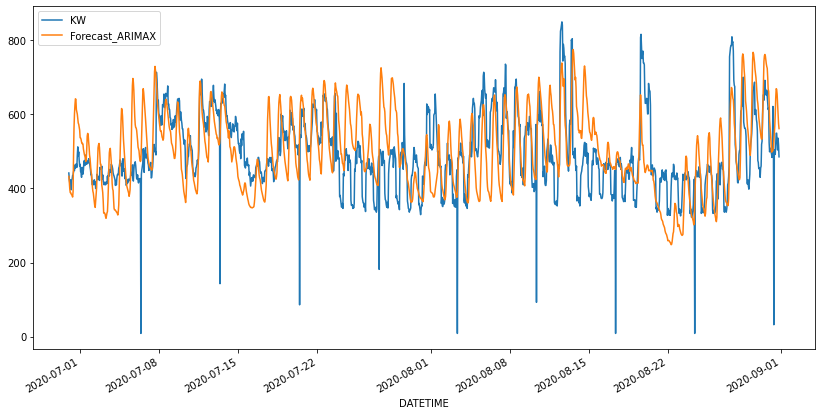

In [19]:
df_valid[["KW", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

In [20]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.KW, df_valid.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.KW, df_valid.Forecast_ARIMAX))

RMSE of Auto ARIMAX: 100.69408652685424

MAE of Auto ARIMAX: 78.002761705449


The Auto ARIMAX model seems to do a fairly good job in predicting the stock price given data till the previous day. Can other models beat this benchmark?


# Facebook Prophet

In [ ]:
model_fbp = Prophet()
for feature in exogenous_features:
    model_fbp.add_regressor(feature)

model_fbp.fit(df_train[["DATETIME", "KW"] + exogenous_features].rename(columns={"DATETIME": "ds", "KW": "y"}))

forecast = model_fbp.predict(df_valid[["DATETIME", "KW"] + exogenous_features].rename(columns={"DATETIME": "ds"}))
df_valid["Forecast_Prophet"] = forecast.yhat.values



INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [2]:
import pandas as pd
print(pd.__version__)

1.0.5


pandas: 1.0.5

In [3]:
import pystan
>>> model_code = 'parameters {real y;} model {y ~ normal(0,1);}'
>>> model = pystan.StanModel(model_code=model_code)
>>> y = model.sampling().extract()['y']
>>> y.mean()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5944b02c79788fa0db5b3a93728ca2bf NOW.


0.021514659189118896

# LightGBM

In [10]:
import lightgbm as lgb
params = {"objective": "regression"}

dtrain = lgb.Dataset(df_train[exogenous_features], label=df_train.KW.values)
dvalid = lgb.Dataset(df_valid[exogenous_features])

model_lgb = lgb.train(params, train_set=dtrain)

forecast = model_lgb.predict(df_valid[exogenous_features])
df_valid["Forecast_LightGBM"] = forecast

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3085
[LightGBM] [Info] Number of data points in the train set: 6834, number of used features: 16
[LightGBM] [Info] Start training from score 608.509079


C:\Users\AshwiniShitole\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


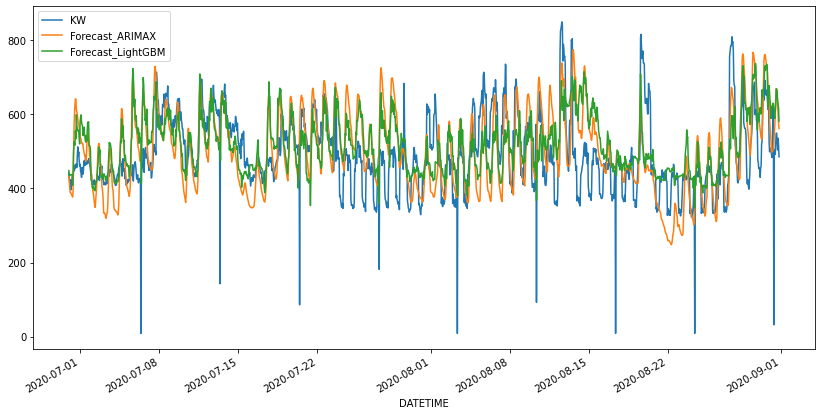

In [15]:
df_valid[["KW", "Forecast_ARIMAX","Forecast_LightGBM"]].plot(figsize=(14, 7))

In [14]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.KW, df_valid.Forecast_ARIMAX)))
print("RMSE of LightGBM:", np.sqrt(mean_squared_error(df_valid.KW, df_valid.Forecast_LightGBM)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.KW, df_valid.Forecast_ARIMAX))
print("MAE of LightGBM:", mean_absolute_error(df_valid.KW, df_valid.Forecast_LightGBM))

RMSE of Auto ARIMAX: 100.69408652685424
RMSE of LightGBM: 98.63773178309955

MAE of Auto ARIMAX: 78.002761705449
MAE of LightGBM: 76.24969576639992


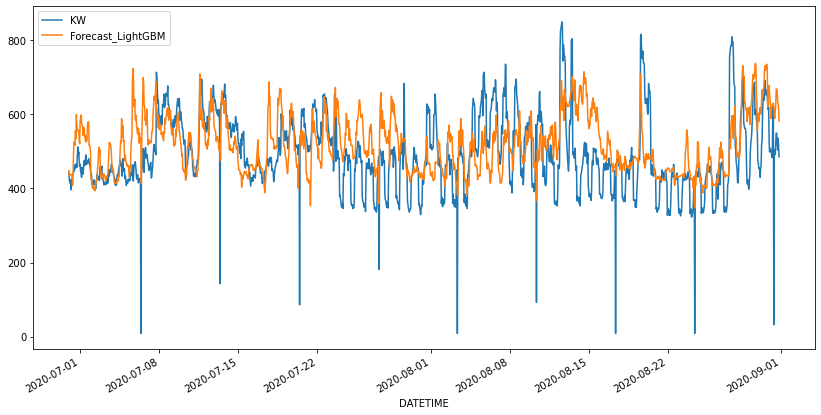

In [19]:
df_valid[["KW","Forecast_LightGBM"]].plot(figsize=(14, 7))

# LightGBM further tunning

In [44]:
import lightgbm as lgb
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 40,
    "learning_rate": 0.2,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse"
}

dtrain = lgb.Dataset(df_train[exogenous_features], label=df_train.KW.values)
dvalid = lgb.Dataset(df_valid[exogenous_features])

watchlist_1 = [dtrain, dvalid]
watchlist_2 = [dvalid, dtrain]

print("Building model with training set:")
model_lgb_1 = lgb.train(params, train_set=dtrain,num_boost_round=1000, valid_sets=watchlist_2, verbose_eval=200, early_stopping_rounds=200)
model_lgb_1.best_iteration


Building model with training set:
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3085
[LightGBM] [Info] Number of data points in the train set: 6834, number of used features: 16
[LightGBM] [Info] Start training from score 608.509079
Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 22.7379	valid_0's rmse: 525.551
Early stopping, best iteration is:
[65]	training's rmse: 45.1334	valid_0's rmse: 525.186


65

In [61]:
print("Validating model with validation set:")
forecast = model_lgb_1.predict(df_valid[exogenous_features],num_iteration=model_lgb_1.best_iteration)
df_valid["Forecast_LightGBM_further_tuning"] = forecast

Validating model with validation set:


C:\Users\AshwiniShitole\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [64]:
print("RMSE of LightGBM:", np.sqrt(mean_squared_error(df_valid.KW, df_valid.Forecast_LightGBM_further_tuning)))
print("MAE of LightGBM:", mean_absolute_error(df_valid.KW, df_valid.Forecast_LightGBM_further_tuning))

RMSE of LightGBM: 98.5252825556613
MAE of LightGBM: 75.45557356358194


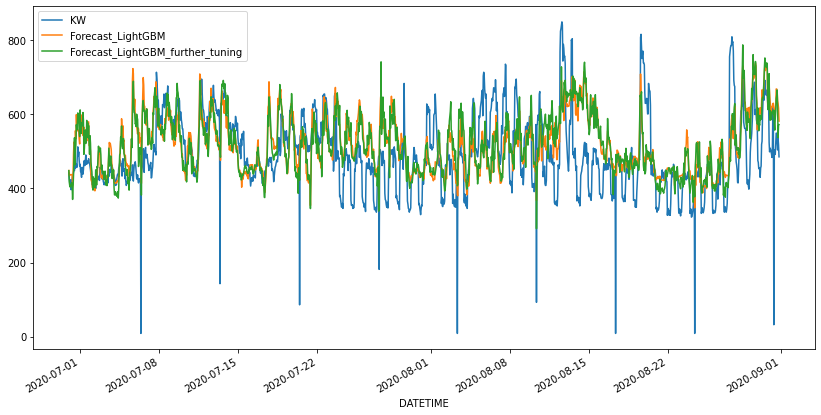

In [65]:
df_valid[["KW","Forecast_LightGBM","Forecast_LightGBM_further_tuning"]].plot(figsize=(14, 7))

In [48]:
df_valid.head()

,DATETIME,TEMP_AIR,UMIDADE_REL,KW,TEMP_AIR_mean_lag3,TEMP_AIR_mean_lag7,TEMP_AIR_mean_lag30,TEMP_AIR_std_lag3,TEMP_AIR_std_lag7,TEMP_AIR_std_lag30,...,UMIDADE_REL_std_lag3,UMIDADE_REL_std_lag7,UMIDADE_REL_std_lag30,month,week,day,day_of_week,Forecast_LightGBM,Forecast_ARIMAX,Forecast_LightGBM_further_tuning
DATETIME,,,,,,,,,,,,,,,,,,,,,
2020-06-30 00:00:00,2020-06-30 00:00:00,14.1,88.0,441.839997,14.900000,15.942857,15.266666,0.360555,1.446671,2.135631,...,1.527525,8.153294,9.364644,6,27,30,1,448.501910,432.606544,447.637523
2020-06-30 01:00:00,2020-06-30 01:00:00,14.1,88.0,425.040009,14.500000,15.328571,15.253333,0.360555,1.101082,2.141822,...,1.000000,6.121780,9.471129,6,27,30,1,435.148728,418.284796,437.983635
2020-06-30 02:00:00,2020-06-30 02:00:00,14.0,88.0,414.959992,14.266666,14.842857,15.250000,0.288675,0.634710,2.143595,...,0.577350,2.214670,9.560515,6,27,30,1,437.580719,398.878378,432.076046
2020-06-30 03:00:00,2020-06-30 03:00:00,13.8,87.0,423.359986,14.066667,14.585714,15.253333,0.057735,0.539841,2.141500,...,0.000000,1.618347,9.647166,6,27,30,1,436.466282,388.909995,432.076046
2020-06-30 04:00:00,2020-06-30 04:00:00,13.7,88.0,414.959992,13.966666,14.385715,15.260000,0.152753,0.533631,2.136481,...,0.577350,1.463850,9.670194,6,27,30,1,437.580719,388.701840,432.076046


In [51]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.KW, df_valid.Forecast_ARIMAX)))
print("RMSE of LightGBM:", np.sqrt(mean_squared_error(df_valid.KW, df_valid.Forecast_LightGBM)))
print("RMSE of LightGBM_tuned:", np.sqrt(mean_squared_error(df_valid.KW, df_valid.Forecast_LightGBM_further_tuning)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.KW, df_valid.Forecast_ARIMAX))
print("MAE of LightGBM:", mean_absolute_error(df_valid.KW, df_valid.Forecast_LightGBM))
print("MAE of LightGBM_tuned:", mean_absolute_error(df_valid.KW, df_valid.Forecast_LightGBM_further_tuning))

RMSE of Auto ARIMAX: 100.69408652685424
RMSE of LightGBM: 98.63773178309955
RMSE of LightGBM_tuned: 97.89585126660931

MAE of Auto ARIMAX: 78.002761705449
MAE of LightGBM: 76.24969576639992
MAE of LightGBM_tuned: 75.40447556044884


In [66]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.KW, df_valid.Forecast_ARIMAX)))
print("RMSE of LightGBM:", np.sqrt(mean_squared_error(df_valid.KW, df_valid.Forecast_LightGBM)))
print("RMSE of LightGBM_tuned:", np.sqrt(mean_squared_error(df_valid.KW, df_valid.Forecast_LightGBM_further_tuning)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.KW, df_valid.Forecast_ARIMAX))
print("MAE of LightGBM:", mean_absolute_error(df_valid.KW, df_valid.Forecast_LightGBM))
print("MAE of LightGBM_tuned:", mean_absolute_error(df_valid.KW, df_valid.Forecast_LightGBM_further_tuning))

RMSE of Auto ARIMAX: 100.69408652685424
RMSE of LightGBM: 98.63773178309955
RMSE of LightGBM_tuned: 98.5252825556613

MAE of Auto ARIMAX: 78.002761705449
MAE of LightGBM: 76.24969576639992
MAE of LightGBM_tuned: 75.45557356358194


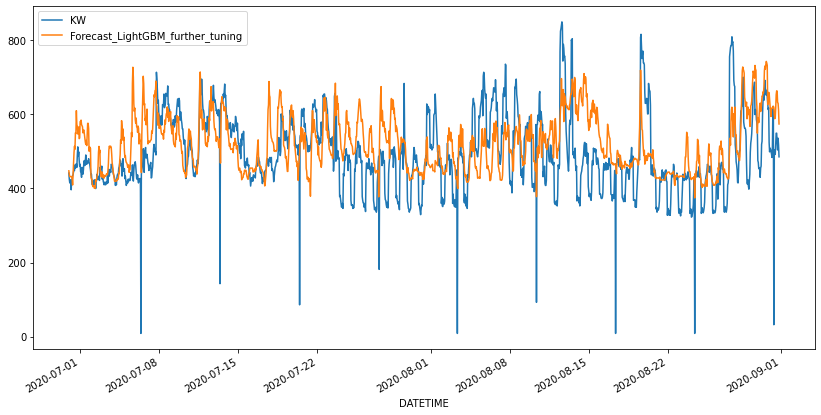

In [60]:
df_valid[["KW","Forecast_LightGBM_further_tuning"]].plot(figsize=(14, 7))

In [67]:
import lightgbm as lgb
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 40,
    "learning_rate": 0.2,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse"
}

dtrain = lgb.Dataset(df_train[exogenous_features], label=df_train.KW.values)
dvalid = lgb.Dataset(df_valid[exogenous_features], label=df_valid.KW.values)

watchlist_1 = [dtrain, dvalid]
watchlist_2 = [dvalid, dtrain]

print("Building model with training set:")
model_lgb_1 = lgb.train(params, train_set=dtrain, num_boost_round=1000, valid_sets=watchlist_1, verbose_eval=200, early_stopping_rounds=200)
model_lgb_1.best_iteration



Building model with training set:
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3085
[LightGBM] [Info] Number of data points in the train set: 6834, number of used features: 16
[LightGBM] [Info] Start training from score 608.509079
Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 22.7379	valid_1's rmse: 98.6892
Early stopping, best iteration is:
[38]	training's rmse: 55.826	valid_1's rmse: 98.1217


38

In [69]:
print("Validating model with validation set:")
forecast = model_lgb_1.predict(df_valid[exogenous_features],num_iteration=model_lgb_1.best_iteration)
df_valid["Forecast_LightGBM_further_tuning"] = forecast

Validating model with validation set:


C:\Users\AshwiniShitole\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [70]:
print("RMSE of LightGBM_Tuned:", np.sqrt(mean_squared_error(df_valid.KW, df_valid.Forecast_LightGBM_further_tuning)))
print("MAE of LightGBM_Tuned:", mean_absolute_error(df_valid.KW, df_valid.Forecast_LightGBM_further_tuning))

RMSE of LightGBM_Tuned: 98.12170314407759
MAE of LightGBM_Tuned: 74.9474822045967


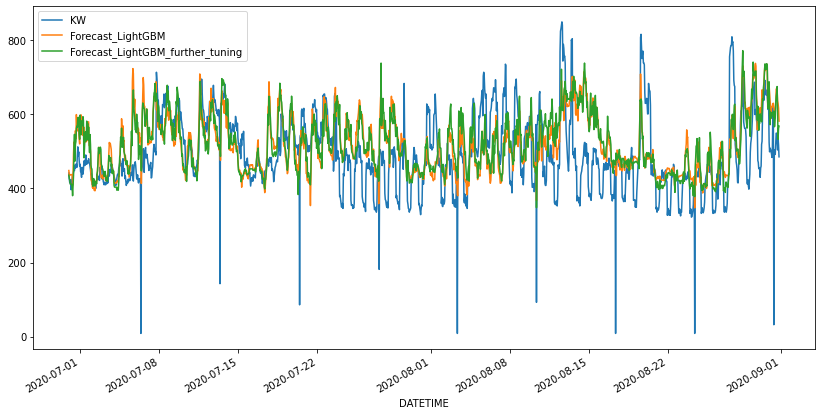

In [71]:
df_valid[["KW","Forecast_LightGBM","Forecast_LightGBM_further_tuning"]].plot(figsize=(14, 7))